In [1]:
import sys, os

sys.path.append('/cr/users/filip/bin')

from utils.binaries import *
from utils.plotting import *

from utils.Auger.SD import Monitoring

10:43:19 [INFO] utils          -- (+35680ms) -- import logging
10:43:19 [INFO] utils.binaries -- (  +107ms) -- import numpy as np
10:43:19 [INFO] utils.binaries -- (   +27ms) -- import uncertainties
10:43:19 [INFO] utils.binaries -- (  +162ms) -- import pandas as pd
10:43:19 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
10:43:19 [INFO] utils.plotting -- (  +486ms) -- import matplotlib.pyplot as plt
10:43:20 [INFO] utils.plotting -- (  +257ms) -- import seaborn as so
10:43:20 [DBUG] utils.plotting -- (    +6ms) -- font size set to 9.5
10:43:20 [DBUG] utils.plotting -- (    +0ms) -- label size set to 13.0
10:43:20 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
10:43:20 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
10:43:20 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
10:43:20 [INFO] utils.plotting -- (    +2ms) -- import plotting.tools as plot


In [2]:
Stations = {'NuriaJr' : 56, 
            'Peru' : 1737, 
            'Granada' : 1738, 
            'Jaco' : 1742, 
            'LeQuiDon' : 1744, 
            'Svenja' : 1733, 
            # 'RukaMalen' : -1
            }
StationIDs, StationNames = list(Stations.values()), list(Stations.keys())

print(StationIDs)
print(StationNames)

[56, 1737, 1738, 1742, 1744, 1733]
['NuriaJr', 'Peru', 'Granada', 'Jaco', 'LeQuiDon', 'Svenja']


# Looking at Online Monitoring

In [3]:
timestamps = [[] for _ in range(len(list(Stations.keys())))]
VEMPeak = [[[], [], []] for _ in range(len(Stations.keys()))]
T1Rates = [[] for _ in range(len(list(Stations.keys())))]


for day in [14, 15, 16, 17, 18, 19]:

    monit = Monitoring.Monit(2023, 3, day)
    fDuration = monit.Calibration.fEndSecond
    fPeak = monit.fCalibration.fPeak
    fRate = monit.fCalibration.fT1
    fTime = monit.fTime

    for i, station in enumerate(StationIDs):
        [timestamps[i].append(val) for val in fTime(station)]
        [T1Rates[i].append(val / dur) for val, dur in zip(fRate(station), fDuration(station))]
        stationPeak = fPeak(station).T

        for j in range(3):
            [VEMPeak[i][j].append(val) for val in stationPeak[j]]


Multiple entries found for Calibration, returning first occurence: fCalibration
Multiple entries found for fCalibration, returning first occurence: fCalibration
Multiple entries found for fCalibration, returning first occurence: fCalibration
Multiple entries found for Calibration, returning first occurence: fCalibration
Multiple entries found for fCalibration, returning first occurence: fCalibration
Multiple entries found for fCalibration, returning first occurence: fCalibration
Multiple entries found for Calibration, returning first occurence: fCalibration
Multiple entries found for fCalibration, returning first occurence: fCalibration
Multiple entries found for fCalibration, returning first occurence: fCalibration
Multiple entries found for Calibration, returning first occurence: fCalibration
Multiple entries found for fCalibration, returning first occurence: fCalibration
Multiple entries found for fCalibration, returning first occurence: fCalibration
Multiple entries found for Calib

NuriaJr: [0.00,  0.01,  0.01] 
Peru: [0.01,  0.01,  0.03] 
Granada: [0.05,  0.01,  0.02] 
Jaco: [0.04,  0.00,  0.01] 
LeQuiDon: [0.01,  0.00,  0.01] 
Svenja: [0.00,  0.01,  0.01] 


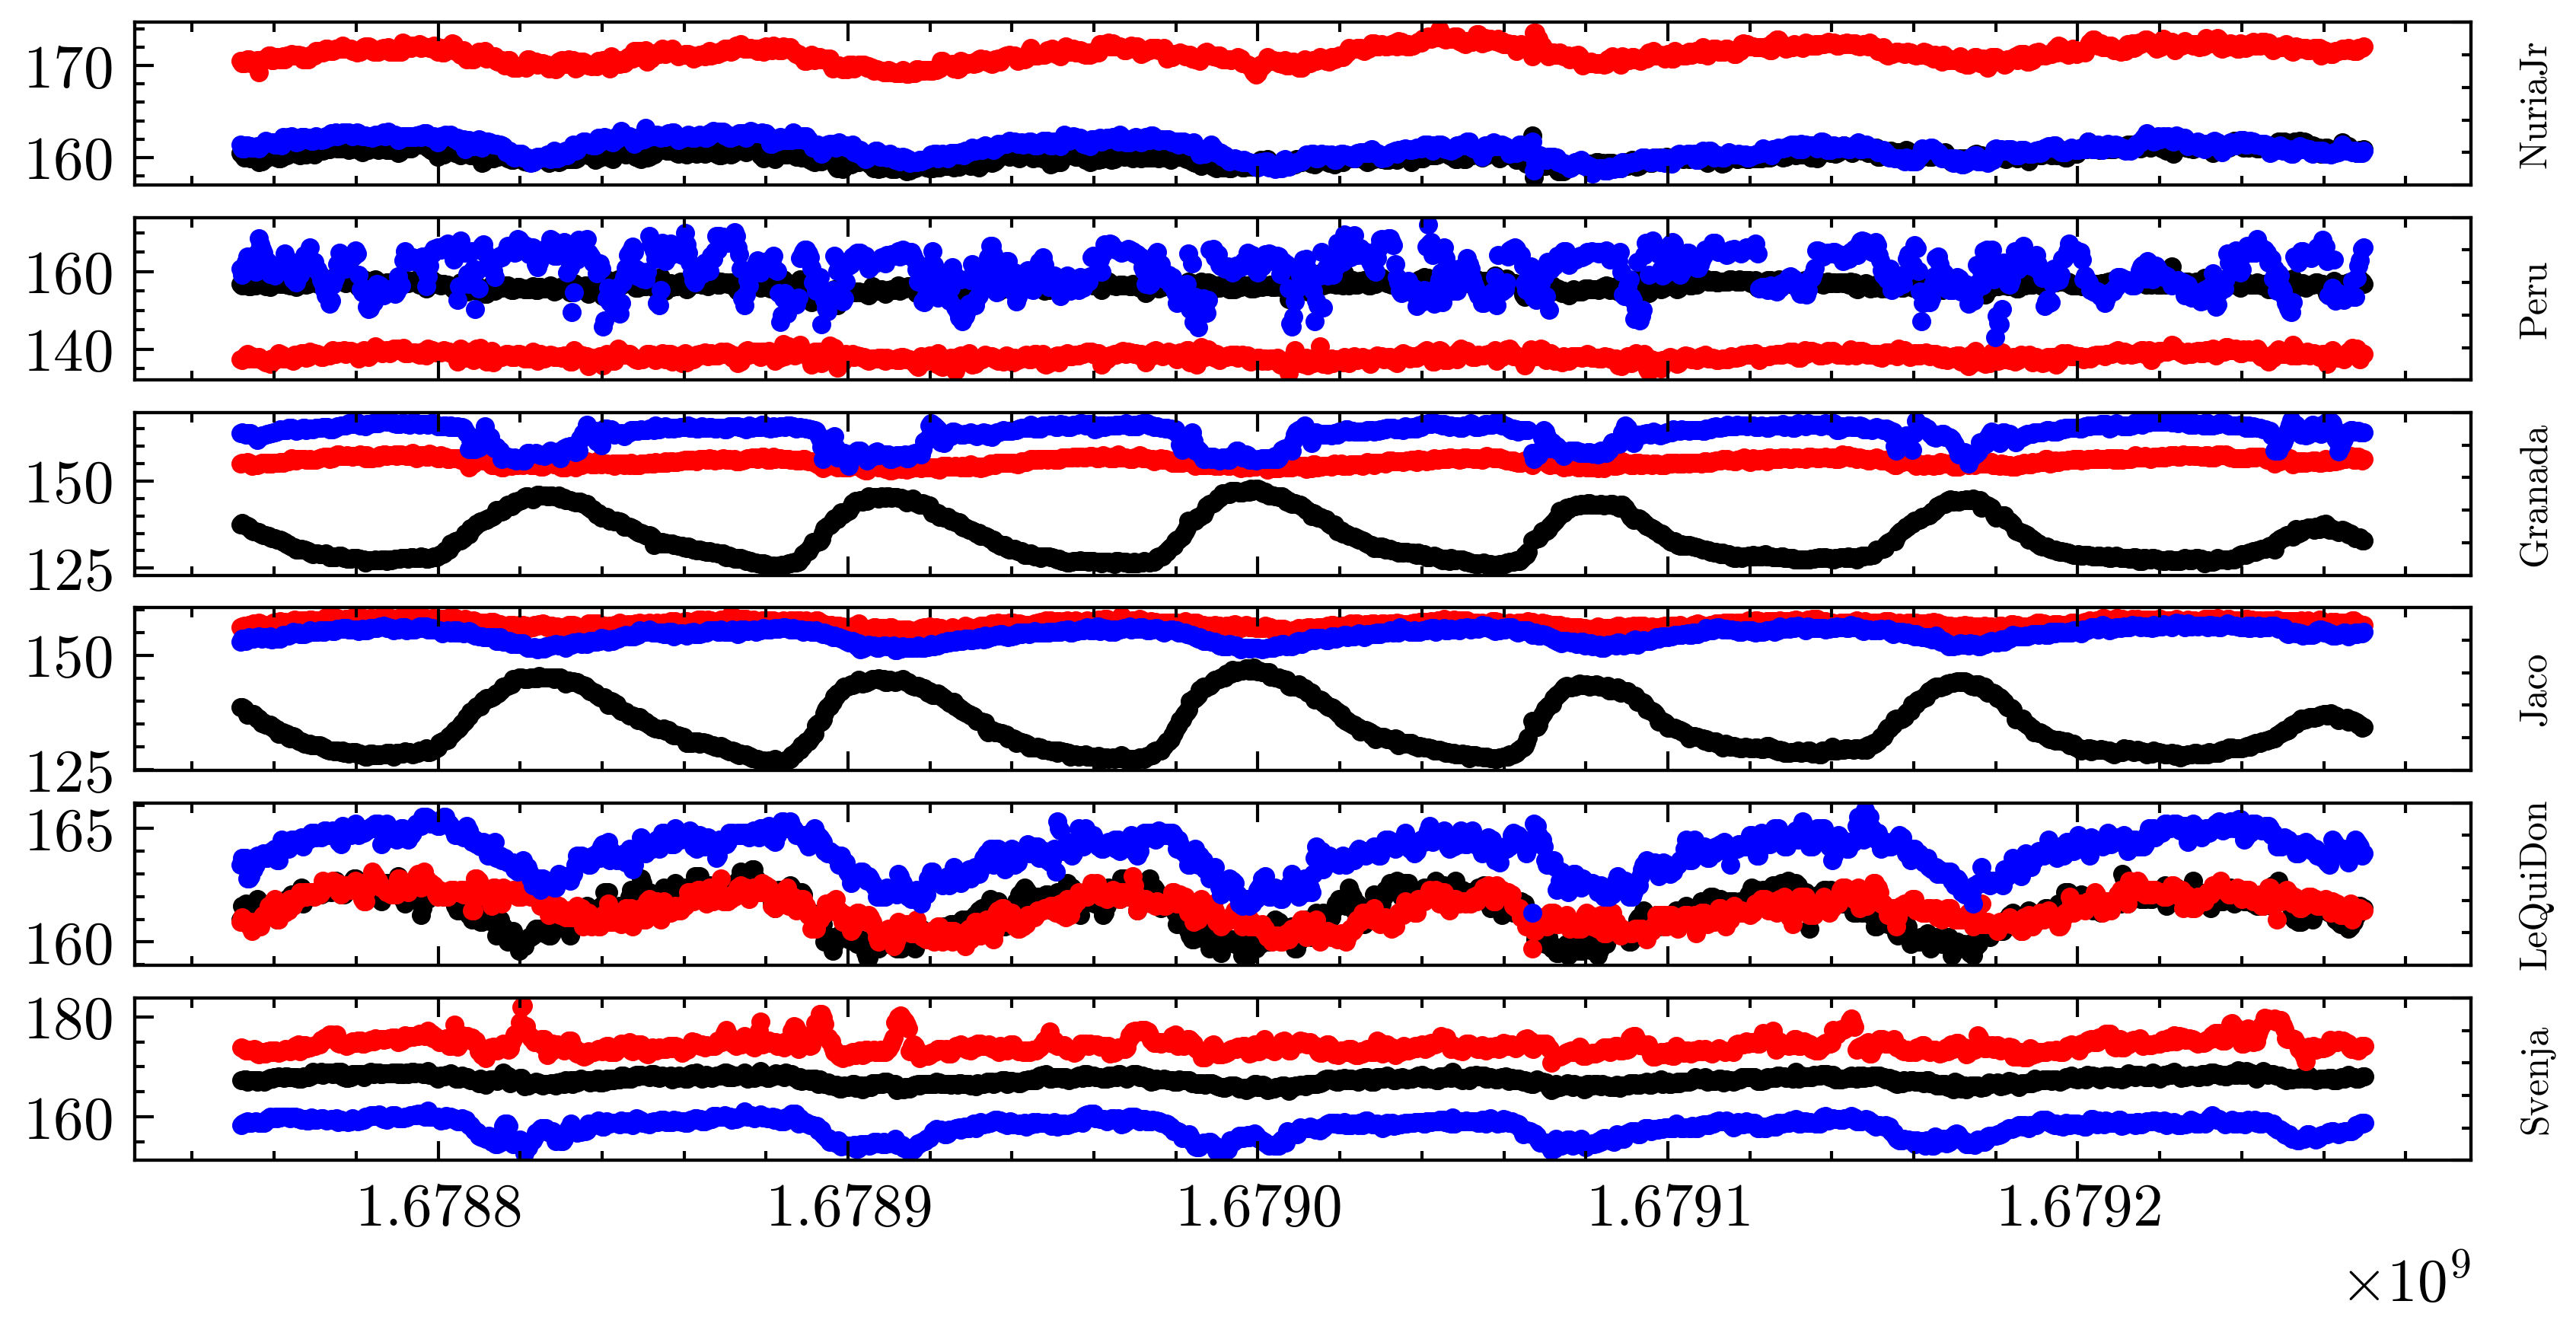

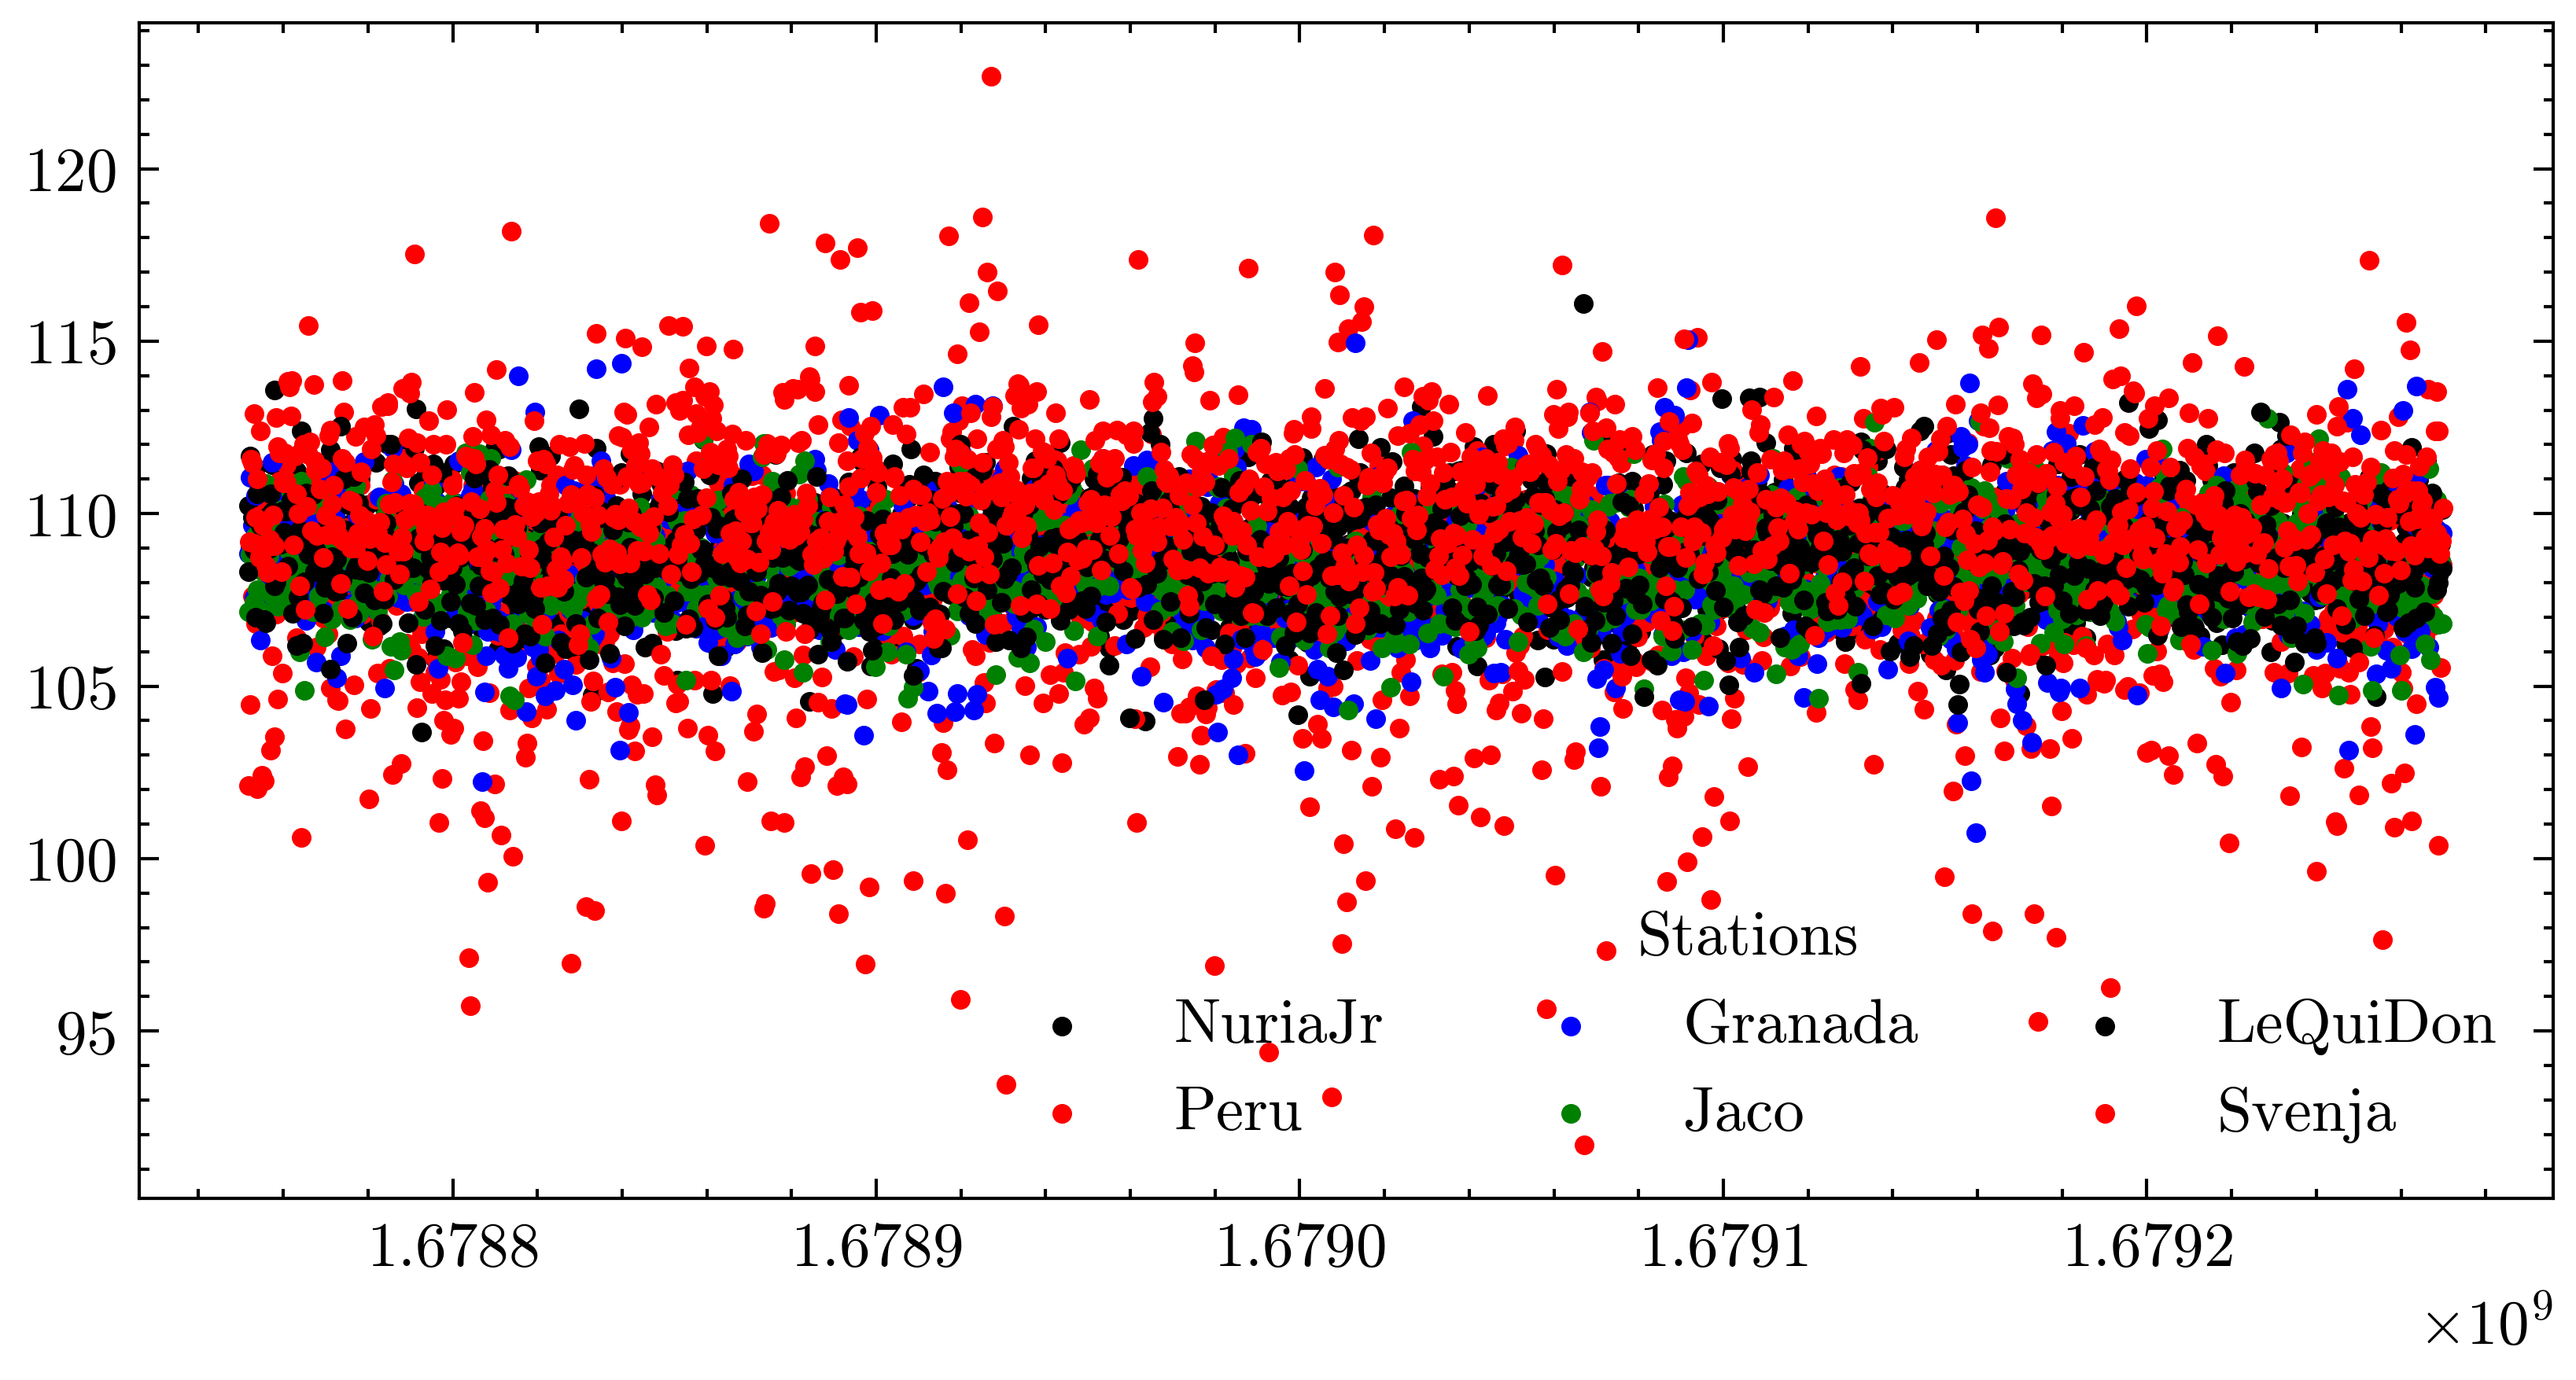

In [5]:
fig, axes = plt.subplots(len(StationIDs), sharex=True)
fig, ax0 = plt.subplots()

for i in range(len(StationIDs)):

    ax = axes[i]
    stationName = StationNames[i]
    t, v, r = timestamps[i], VEMPeak[i], T1Rates[i]

    ax.scatter(t, v[0], label='PMT #1')
    ax.scatter(t, v[1], label='PMT #2')
    ax.scatter(t, v[2], label='PMT #3')
    # ax.legend(title=stationName)

    print(f"{stationName}:", end=" ")
    print(f"[{np.std(v[0]) / np.mean(v[0]) :.2f}, ", end=" ")
    print(f"{np.std(v[1]) / np.mean(v[1]) :.2f}, ", end=" ")
    print(f"{np.std(v[2]) / np.mean(v[2]) :.2f}] ")

    axName = ax.twinx()
    axName.set_yticklabels([])
    axName.set_ylabel(stationName, fontsize=6)
    ax0.scatter(t, r , label=stationName)

ax0.legend(title='Stations', ncol=3)

# ax0.set_ylim()
    # _ = ax.set_xticks([dt.datetime.timestamp(then) for then in [dt.datetime(2022, 11, d) for d in [14, 15, 16, 17, 18, 19]]], [dt.datetime(2022, 11, d) for d in [14, 15, 16, 17, 18, 19]])

# ax.set_xlabel("Station time / UTC")

